A script to draw a network map of a company's officers/PSCs and their interests in other companies, in order to see how intertwined they are.

Works for companies in the registry of the UK's Companies House.

In [1]:
# import libraries
import pandas as pd
from bs4 import BeautifulSoup, Tag
import requests
import matplotlib as plt
import time
import matplotlib.pyplot as plt 
import matplotlib.dates as mpdates
import numpy as np
import math
import networkx as nx

In [2]:
# A function that returns a dataframe of all the officers and persons with significant control of a company.

def companyDetails(company_name,company_number):
    
    df = pd.DataFrame(columns=['Company','Person','Person Type','Address','Status','Role','Appointed/Notified','Resigned/Ceased', "Officer URL ID"])
    
    ### OFFICERS
    url = f'https://find-and-update.company-information.service.gov.uk/company/{company_number}/officers'
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
        
    n = 1000
    for i in range(1,n):
        
        if soup.find(id=f'officer-name-{i}') != None:
            
            next_row = df.shape[0] + 1
            df.loc[next_row,'Company'] = company_name
            df.loc[next_row,'Person'] = soup.find(id=f'officer-name-{i}').contents[1].contents[0] if soup.find(id=f'officer-name-{i}').find('a') != None else soup.find(id=f'officer-name-{i}')
            df.loc[next_row,'Person Type'] = 'Officer'
            df.loc[next_row,'Address'] = soup.find(id=f'officer-address-value-{i}').contents[0].replace('\n','')
            df.loc[next_row,'Status'] = soup.find(id=f'officer-status-tag-{i}').contents[0] if soup.find(id=f'officer-status-tag-{i}') != None else None
            df.loc[next_row,'Role'] = soup.find(id=f'officer-role-{i}').contents[0].replace('\n','')
            df.loc[next_row,'Appointed/Notified'] = soup.find(id=f'officer-appointed-on-{i}').contents[0].replace('\n','') if soup.find(id=f'officer-appointed-on-{i}') != None else None
            df.loc[next_row,'Resigned/Ceased'] = soup.find(id=f'officer-resigned-on-{i}').contents[0].replace('\n','') if soup.find(id=f'officer-resigned-on-{i}')!=None else None
            df.loc[next_row,'Officer URL ID'] = soup.find(id=f'officer-name-{i}').find('a').get('href').split('/')[2] if soup.find(id=f'officer-name-{i}').find('a') != None else None
                        
        else:
            break
            
            
    ### PERSONS WITH SIGNIFICANT CONTROL 
    url = f'https://find-and-update.company-information.service.gov.uk/company/{company_number}/persons-with-significant-control'
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
       
    for i in range(1,n):   
        if soup.find(id=f'psc-name-{i}') != None:
            
            person_raw = soup.find(id=f'psc-name-{i}')  
            for n in range(0, len(person_raw)):
                if len(str(person_raw.contents[n])) > 1:
                    person = person_raw.contents[n].string
            
            next_row = df.shape[0] + 1         
            df.loc[next_row,'Company'] = company_name
            df.loc[next_row,'Person'] = person
            df.loc[next_row,'Person Type'] = 'Person with Significant Control'
            df.loc[next_row,'Status'] = soup.find(id=f'psc-status-tag-{i}').contents[0] if soup.find(id=f'psc-status-tag-{i}') != None else None
            df.loc[next_row,'Address'] = soup.find(id=f'psc-address-value-{i}').contents[0].replace('\n','')
            df.loc[next_row,'Appointed/Notified'] = soup.find(id=f'psc-notified-on-{i}').contents[0].replace('\n','')
            df.loc[next_row,'Resigned/Ceased'] = soup.find(id=f'psc-ceased-on-{i}').contents[0].replace('\n','') if soup.find(id=f'psc-ceased-on-{i}')!=None else None
   
        else:
            break
            
    df.to_csv(f'df_{company_name}.csv')
    
    return df

In [3]:
### A function that creates DataFrames as CSVs for Officers.

def officerDetails(officer_name,url):
    
    officer_columns = ['Person','Company','Company ID','Company Status','Role','Officer Status','Appointed', 'Resigned']    
    df = pd.DataFrame(columns=officer_columns)

    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
        
    appts = int(soup.find(id = 'personal-appointments').contents[0].strip().split(' ')[-1])
        
    def infoScraper(soup, i):       
        
        if soup.find(id=f'company-name-{i}') != None:
        
            co = soup.find(id=f'company-name-{i}').contents[1].contents[0] if soup.find(id=f'company-name-{i}').find('a') != None else soup.find(id=f'company-name-{i}')
            company_name = co[:-10].strip()
            company_number = co[-10:]

            next_row = df.shape[0] + 1
            df.loc[next_row,'Person'] = officer_name
            df.loc[next_row,'Company'] = company_name
            df.loc[next_row,'Company ID'] = company_number.replace('(','').replace(')','')
            df.loc[next_row,'Company Status'] = soup.find(id=f'company-status-value-{i}').contents[0].replace('\n','')
            df.loc[next_row,'Role'] = soup.find(id=f'appointment-type-value{i}').contents[0].replace('\n','')

            if 'Active' in str(soup.find(id=f'appointment-type-field-{i}')):
                status = 'Active'
            elif 'Resigned' in str(soup.find(id=f'appointment-type-field-{i}')):
                status = 'Resigned'
            else:
                status = None
            df.loc[next_row,'Officer Status'] = status 

            df.loc[next_row,'Appointed'] = soup.find(id=f'appointed-value{i}').contents[0].replace('\n','')
            df.loc[next_row,'Resigned'] = soup.find(id=f'resigned-value-{i}').contents[0].replace('\n','') if soup.find(id=f'resigned-value-{i}') != None else None

            
    for i in range(1,appts+1):
        
        if i <= 35:
            infoScraper(soup,i)
        else:
            if (i-1) % 35 == 0:
                p = int((i-1) / 35)
                new_url = f'{url}?page={p+1}'
                new_page = requests.get(new_url)                                
                new_soup = BeautifulSoup(new_page.content, 'html.parser')
                
            infoScraper(new_soup, i - (35*p))
            
                    
    df.to_csv(f'df_{officer_name}.csv')
    
    print(officer_name, appts)
    
    return df

In [4]:
### A function that creates a dataframe as a CSV for each Person with Significant Control

def pscDetails():

    df = pd.DataFrame(columns=['Company','Company ID','Company Status','Role','Officer Status','Appointed', 'Resigned'])

    url_id = input("What is the company's code?")
    url = f'https://find-and-update.company-information.service.gov.uk/officers/{url_id}/appointments'
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    
    print(soup.find_all('a'))
    
#pscDetails()

In [5]:
def getCompanyName():
    
    starting_company_number = input("What is the company's code?")
    
    url = f'https://find-and-update.company-information.service.gov.uk/company/{starting_company_number}/officers'
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    
    starting_company = soup.find(class_="heading-xlarge").string
    
    print(starting_company)
    
    return starting_company, starting_company_number

In [6]:
def getData():
    
    starting_company, starting_company_number = getCompanyName()
    
    df_COMPANY = companyDetails(starting_company, starting_company_number)

    for officer_name in df_COMPANY.loc[df_COMPANY['Person Type'] == 'Officer','Person']:

            url_id = df_COMPANY.loc[df_COMPANY['Person']==officer_name,'Officer URL ID'].values[0]
            url = f'https://find-and-update.company-information.service.gov.uk/officers/{url_id}/appointments'

            df = officerDetails(officer_name, url)
                            
            try:
                df_OFFICERS = pd.concat([df_OFFICERS,df], axis=0)
            except:
                df_OFFICERS = df
                   
    ### PSCs
    
        
    return starting_company, starting_company_number, df_COMPANY, df_OFFICERS

In [7]:
outer_circle_weights = {}
inner_circle_weights = {}

def circle_weights():   #
    
    inner_circle = set(G.neighbors(starting_company))
    
    for node in G.nodes():
        if len(nx.shortest_path(G,node,starting_company)) == 3:
            weight = len(set(G.neighbors(node)).intersection(inner_circle)) - 1     ### minus the inner node we are looking at
            
            outer_circle_weights[node] = weight
            
    for node in inner_circle:
        weight = 0
        
        #print(node)
        
        neighbors = set(G.neighbors(node))        
        neighbors.remove(starting_company)
        neighbors = neighbors - inner_circle
        
        for neighbor in neighbors:
                
                weight += outer_circle_weights[neighbor]
                
                #print('\t',neighbor[:45], ' ' * (45-len(neighbor)), outer_circle_weights[neighbor],'\t',weight)
                
        #print(weight)
        #print()
        
        inner_circle_weights[node] = weight

In [64]:
def plotGraph(width,height):
    
    ### Create nodes
    
    G.add_node(starting_company,type='Starting Company')
    
    officers = list(df_COMPANY.loc[df_COMPANY['Person Type']=='Officer','Person'])
    pscs = list(df_COMPANY.loc[df_COMPANY['Person Type']=='Person with Significant Control','Person'])
    inner_circle = officers + pscs
    
    for person in inner_circle:
        person_type = df_COMPANY.loc[df_COMPANY['Person']==person,'Person Type'].values[0]
        G.add_node(person,type=person_type)
        G.add_edge(person,starting_company)
        
        third_parties = set(df_OFFICERS.loc[df_OFFICERS['Person'] == person, 'Company'])
        for third_party in third_parties:
                            
            if third_party not in inner_circle and third_party != starting_company:
                G.add_node(third_party,type="Third Party")
                G.add_edge(third_party,person)
        
        
        # PSCs
        
    
    
    # Graphical Details
    
    circle_weights()  #

    plt.figure(1,figsize=(width,height)) 
    pos = nx.spring_layout(G,k=0.125, iterations=50)
    

    color_map, node_sizes = [], []
    colorMatch = {'Starting Company':'yellow', 'Third Party':'aquamarine', 'Officer': 'violet', 'Person with Significant Control': 'salmon'}
    
    for node in G.nodes(data=True):            
                
            color_map.append(colorMatch[node[1]['type']])
            
            # node size for those is inner circle is an equal proportion of the mother hub / divided by its children then times by the number of interconnections to third parties it has 
            node_unit = 5
            starting_company_node_size = node_unit * 1000
            
            if node[1]['type'] == 'Third Party':
                    
                    nodeSizer = node_unit * 10                         
                    weight = (outer_circle_weights[node[0]] + 1)
                    nodeSizer *= (weight**2)/4
                                    
            elif node[0] in inner_circle:
                                
                if node[1]['type'] == 'Officer':
                    nodeSizer = starting_company_node_size / len(inner_circle)
                    nodeSizer += (inner_circle_weights[node[0]] * 10 * node_unit)
                elif node[1]['type'] == 'Person with Significant Control':
                    nodeSizer = starting_company_node_size * 0.75
                    
            
            if node[0] == starting_company:
                nodeSizer = starting_company_node_size
                     
            node_sizes.append(nodeSizer)
            
                       
    for node, (x, y) in pos.items():  
                
            text_unit = 10
            starting_company_text_size = text_unit * 2
                
            if node == starting_company:
                    
                textSizer = starting_company_text_size
                    
                node_text = node
                if node_text.split(' ')[-1].upper() == 'LIMITED':
                    node_text = '\n'.join(node_text.split(' ')[:-1])
        
                    #plt.text(x, y, str(node_text), fontsize=textSizer, ha='center', va='center')
                    
            elif node in officers:
                textSizer = text_unit
                textSizer += inner_circle_weights[node]/6
                    
                if ',' in node:
                    node_text = node.replace(',','\n')
                    #plt.text(x, y, str(node_text), fontsize=textSizer, ha='center', va='center')
                        
                else:
                    node_text = node.replace('LIMITED','').replace('LTD','')
                    #plt.text(x, y, str(node.replace('LIMITED','').replace('LTD','')), fontsize=textSizer, ha='center', va='center')
                      
            elif node in pscs:
                textSizer = starting_company_text_size*0.75
                    
                node_text = node.upper().replace('LIMITED','').replace('LTD','').strip()
                                        
                if len(node_text.split(' ')) == 2:
                    a = len(node_text.split(' ')[0])
                    b = len(node_text.split(' ')[1])
                    if abs(a-b) < (a+b)/3:
                           node_text = node_text.replace(' ','\n')
                            
                    
                    
            else: 
                node_text = node.upper().replace('LIMITED','').replace('LTD','').strip()
                weight = (outer_circle_weights[node] + 1) * 0.25
                textSizer = text_unit * weight
                #plt.text(x, y, str(node_text), fontsize=textSizer, ha='center', va='center', color='k')
               
            
            
            if textSizer > starting_company_text_size:
                textSizer = starting_company_text_size + ((textSizer - starting_company_text_size)/10)
            plt.text(x, y, str(node_text), fontsize=textSizer, ha='center', va='center')
    
    nx.draw(G, pos, alpha=0.45, node_color=color_map, node_size=node_sizes, hoverinfo = 'text', edge_color='gainsboro', node_shape="o", linewidths=1, edgecolors='k')

    plt.show() 

In [65]:
#plotGraph(52,37)

What is the company's code? 03442228


LIVERPOOL FOOTBALL CLUB LIMITED
ROBERTS, Joanne 1
HUGHES, Andrew Lawrence 56
BLACKMORE SECRETARIAL SERVICES LIMITED 17
JONES, Ronald 12
MORRISON, William Bryce 12
NASH, Philip 1
WIGNALL, Natalie 1
AYRE, Ian 24
CHESTNUTT, David Moore Alexander 39
COFFMAN, Casey Ann 16
GILLETT, Foster Lockhart 19
GILLETT JNR, George Nield 15
GROSVENOR MANAGEMENT SERVICES LIMITED 17
HICKS, Thomas Ollis 18
HICKS JNR, Thomas Ollis 16
NASH, Philip Tudor 20
PARRY, Richard Nicholas 18


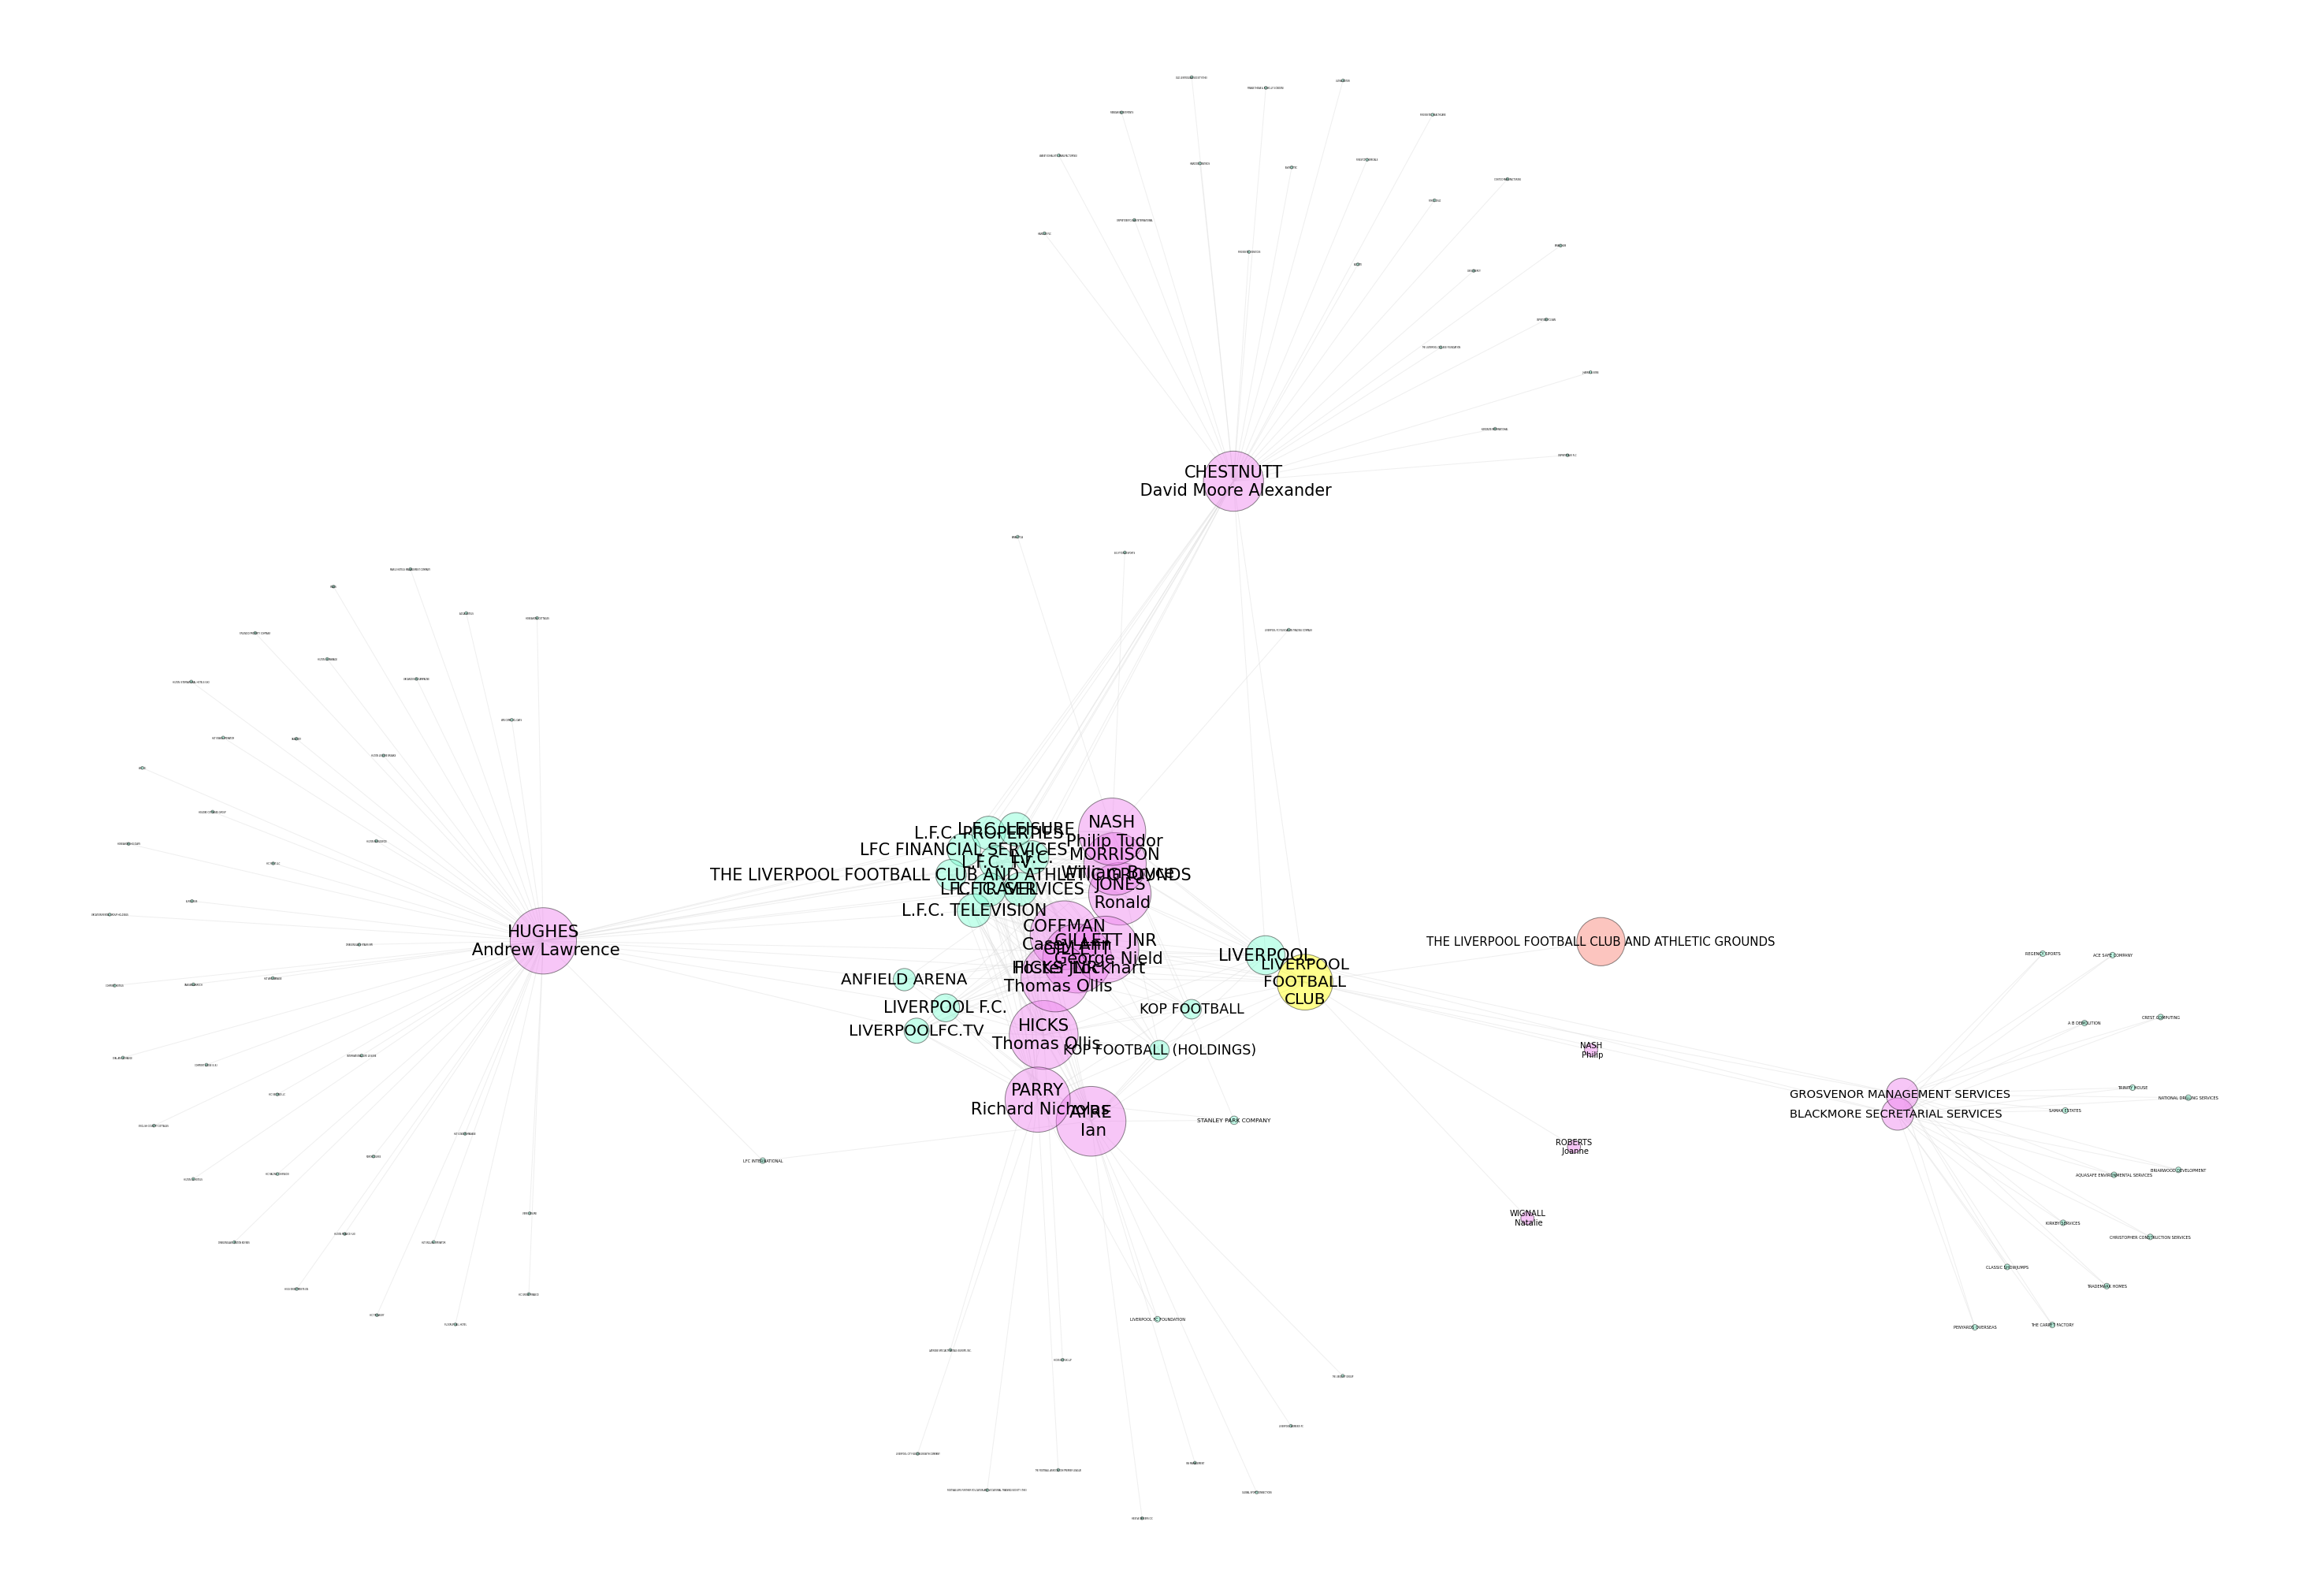

In [67]:
G = nx.Graph()
starting_company, starting_company_number, df_COMPANY, df_OFFICERS = getData()
plotGraph(52,37)  